Universidade Federal Fluminense

Disciplina: Gerência de Grande Volumes de Dados

Turma: Mestrado 2023-1

Alunos:

  Matheus Veloso

  Alexandre Gantos

  Lucas Dirk

  Gustavo Silva


Este trabalho tem como objetivo processar e analisar os dados disponíveis sobre o preço de venda dos combustíveis em territorio nacional brasileiro. Utilizando o Spark e a linguagem de programação Python. A ananlise exploratoria desse  ados visa responder á variação de preço dos combustíveis

In [ ]:
# Conectammos ao Google Drive para consumir a pasta arquivo_carga onde se encontra dos os CSV com os dados das coletas.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Instalar as dependências

#Instalar Java 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

#Realizar o download do Spark
!wget -q https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz

#Descompartar o arquivo baixado
!tar xf spark-3.4.0-bin-hadoop3.tgz

#Instalando a findspark
!pip install -q findspark

In [ ]:
#Configurar as variáveis de ambiente

#Importando a biblioteca os
import os

#Definindo a variável de ambiente do Java
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

#Definindo a variável de ambiente do Spark
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"

#Importando a findspark
import findspark

#Iniciando o findspark
findspark.init('spark-3.4.0-bin-hadoop3')

In [ ]:
# iniciar uma sessão local
from pyspark.sql import SparkSession
import time
from pyspark.sql.functions import *
sc = SparkSession.builder.master('local[*]').config('spark.ui.port', '4050').getOrCreate()

In [ ]:
# Lendo os arquivos CSV de 2004 até 2022


df = sc.read.csv("/content/drive/MyDrive/Colab Notebooks/Big_Data_UFF/Trabalho_Final_BigData/Apresentação/Arquivos_Carga", sep=';', header=True)


In [ ]:
# Nessa etapa nomeamos as colunas e mudamos o tipagem delas e excluimos colunas que não era necessaria para nossa analise

df_transformado = df.withColumnRenamed("Regiao - Sigla", "regiao") \
            .withColumnRenamed("Estado - Sigla", "uf") \
            .withColumnRenamed("Municipio", "municipio") \
            .withColumnRenamed("Bairro", "bairro") \
            .withColumnRenamed("Produto", "produto") \
            .withColumn("data", to_date(col('Data da Coleta'), 'MM/dd/yyyy'))\
            .withColumnRenamed("CNPJ da Revenda", "cnpj") \
            .withColumnRenamed("Produto", "produto") \
            .withColumnRenamed("Bandeira", "bandeira") \
            .withColumn("venda", regexp_replace(col("Valor de Venda"), ",", ".").cast("float")) \
            .withColumnRenamed("Unidade de Medida", 'unidade_medida') \
            .withColumn("ano_coleta", year("data"))\
            .drop("Revenda", "Nome da Rua", "Numero Rua", "Revenda", "Nome da Rua", "Numero Rua", "Complemento", "Cep", "Valor de Venda", "Valor de Compra", "Data da Coleta")

In [ ]:
# Escrevendo em parquet para otimizar

df_transformado.write.mode('overwrite').parquet("/content/drive/MyDrive/Colab Notebooks/Big_Data_UFF/Trabalho_Final_BigData/Apresentação/Silver")

In [ ]:
# Iniciar contagem de tempo
start_time = time.time()

df_base = sc.read.parquet("/content/drive/MyDrive/Colab Notebooks/Big_Data_UFF/Trabalho_Final_BigData/Apresentação/Silver")

# Calcular o tempo de carregamento

end_time = time.time()
total_time = end_time - start_time

# Imprimir o tempo de carregamento
print("Tempo de carregamento utilizando Spark : %.2f segundos" % total_time)

Tempo de carregamento utilizando Spark : 0.69 segundos


In [ ]:
# Obter os anos distintos em ordem decrescente
anos_distintos = df_base.select("ano_coleta").distinct().orderBy("ano_coleta", ascending=False)

# Exibir os anos distintos em ordem decrescente
anos_distintos.show()

+----------+
|ano_coleta|
+----------+
|      2022|
|      2021|
|      2020|
|      2019|
|      2018|
|      2017|
|      2016|
|      2015|
|      2014|
|      2013|
|      2012|
|      2011|
|      2010|
|      2009|
|      2008|
|      2007|
|      2006|
|      2005|
|      2004|
|      null|
+----------+



In [ ]:
df_base.show()

+------+---+------------+-------------------+----------+----------+--------------+--------------------+----------+-----+----------+
|regiao| uf|   municipio|               cnpj|    bairro|   produto|unidade_medida|            bandeira|      data|venda|ano_coleta|
+------+---+------------+-------------------+----------+----------+--------------+--------------------+----------+-----+----------+
|    SE| SP|   GUARULHOS| 49.051.667/0001-02|BONSUCESSO|  GASOLINA|    R$ / litro|PETROBRAS DISTRIB...|2014-02-01|2.899|      2014|
|    SE| SP|   GUARULHOS| 49.051.667/0001-02|BONSUCESSO|    ETANOL|    R$ / litro|PETROBRAS DISTRIB...|2014-02-01|1.949|      2014|
|    SE| SP|   GUARULHOS| 49.051.667/0001-02|BONSUCESSO|    DIESEL|    R$ / litro|PETROBRAS DISTRIB...|2014-02-01|2.399|      2014|
|    SE| SP|   GUARULHOS| 49.051.667/0001-02|BONSUCESSO|DIESEL S10|    R$ / litro|PETROBRAS DISTRIB...|2014-02-01|2.569|      2014|
|    SE| SP|   GUARULHOS| 49.051.667/0001-02|BONSUCESSO|       GNV|       R$

In [ ]:
df_brent = sc.read.csv("/content/drive/MyDrive/Colab Notebooks/Big_Data_UFF/Trabalho_Final_BigData/Apresentação/Arquivos_Auxiliares/Petroleo_Historico.csv", sep=',', header=True)
df_usd = sc.read.csv("/content/drive/MyDrive/Colab Notebooks/Big_Data_UFF/Trabalho_Final_BigData/Apresentação/Arquivos_Auxiliares/Cambio_Historico.csv", sep=',', header=True)
df_latlon = sc.read.csv("/content/drive/MyDrive/Colab Notebooks/Big_Data_UFF/Trabalho_Final_BigData/Apresentação/Arquivos_Auxiliares/municipios.csv", sep=',', header=True)
df_latlon_e = sc.read.csv("/content/drive/MyDrive/Colab Notebooks/Big_Data_UFF/Trabalho_Final_BigData/Apresentação/Arquivos_Auxiliares/estados.csv", sep=',', header=True)

In [ ]:

df_brent.createOrReplaceTempView("temp_table")
df_brent = sc.sql("SELECT TO_DATE(`Data`, 'dd.MM.yyyy') data, CAST(REPLACE(`Último`, ',', '.') AS FLOAT) ultimo, CAST(REPLACE(`Abertura`, ',', '.') AS FLOAT) abertura, CAST(REPLACE(`Máxima`, ',', '.') AS FLOAT) maxima, CAST(REPLACE(`Mínima`, ',', '.') AS FLOAT) minima FROM temp_table")

df_usd.createOrReplaceTempView("temp_table")
df_usd = sc.sql("SELECT TO_DATE(`Data`, 'dd.MM.yyyy') data, CAST(REPLACE(`Último`, ',', '.') AS FLOAT) ultimo, CAST(REPLACE(`Abertura`, ',', '.') AS FLOAT) abertura, CAST(REPLACE(`Máxima`, ',', '.') AS FLOAT) maxima, CAST(REPLACE(`Mínima`, ',', '.') AS FLOAT) minima FROM temp_table")

In [ ]:
#JOIN DAS TABELAS
df_base.createOrReplaceTempView("df_base")
df_brent.createOrReplaceTempView("df_brent")
df_usd.createOrReplaceTempView("df_usd")

df_join = sc.sql("""
                SELECT base.*, usd.ultimo as usd,  base.venda/usd.ultimo as venda_usd, brent.ultimo as brent, base.venda/(usd.ultimo*brent.ultimo) as venda_brent
                from df_base  base
                left join df_brent brent ON year(base.data) = year(brent.data) and month(base.data) = month(brent.data)
                left join df_usd usd ON year(base.data) = year(usd.data) and month(base.data) = month(usd.data)
                """)
df_join.createOrReplaceTempView("df_join")

df_join_v2 = sc.sql("""
                    SELECT *
                    FROM df_join
                    WHERE produto='GASOLINA'
                    """)
df_join_v2=df_join_v2.dropna()

In [ ]:
df_join_v2.show()

+------+---+------------+-------------------+--------------------+--------+--------------+--------------------+----------+-----+----------+------+------------------+------+--------------------+
|regiao| uf|   municipio|               cnpj|              bairro| produto|unidade_medida|            bandeira|      data|venda|ano_coleta|   usd|         venda_usd| brent|         venda_brent|
+------+---+------------+-------------------+--------------------+--------+--------------+--------------------+----------+-----+----------+------+------------------+------+--------------------+
|    SE| SP|   GUARULHOS| 49.051.667/0001-02|          BONSUCESSO|GASOLINA|    R$ / litro|PETROBRAS DISTRIB...|2014-02-01|2.899|      2014|2.3381| 1.239895634638434|108.63|0.011413934093221504|
|     S| RS|PORTO ALEGRE| 91.438.796/0001-14|           CAVALHADA|GASOLINA|    R$ / litro| COSAN LUBRIFICANTES|2014-02-01|2.999|      2014|2.3381|1.2826654669429132|108.63|0.011807654365689289|
|     N| AC|  RIO BRANCO| 08.2

In [ ]:
def remover_acentos(texto):
    return unidecode(texto)
!pip install unidecode
from unidecode import unidecode
from pyspark.sql.functions import udf

# Definir uma função UDF (User Defined Function) para remover acentos
remover_acentos_udf = udf(lambda x: unidecode(x) if x else x)

df_join_v2 = df_join_v2[year(df_join_v2['data'])==2022]
df_join_grp = df_join_v2.groupBy('municipio').agg(avg("venda").alias("venda"))
df_join_grp.createOrReplaceTempView("df_join_grp")
df_latlon = df_latlon.withColumn("nome", remover_acentos_udf("nome"))
df_latlon.createOrReplaceTempView("df_join_MUN")
df_join_grp_v2 = sc.sql("""
                    SELECT a.*,b.latitude,b.longitude
                    FROM df_join_grp a
                    left join df_join_MUN b on upper(a.municipio) = upper(b.nome)
                    WHERE latitude is not null
                    """)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 5.1 MB/s eta 0:00:00


In [ ]:

df_join_grp_v2.show()

+--------------------+------------------+--------+---------+
|           municipio|             venda|latitude|longitude|
+--------------------+------------------+--------+---------+
|       FOZ DO IGUACU| 6.293999934646319|-25.5427| -54.5827|
|            LINHARES| 6.556158143921761|-19.3946| -40.0643|
|  SAO JOAO DE MERITI| 6.375975562304985|-22.8058| -43.3729|
|             BRUSQUE|  6.32327778869205|-27.0977| -48.9107|
| TEIXEIRA DE FREITAS|6.6142646284664375|-17.5399|   -39.74|
|          ACAILANDIA| 6.418684187688325|-4.94714| -47.5004|
|     CRUZEIRO DO SUL| 7.460609720974434|-7.62762| -72.6756|
|     CRUZEIRO DO SUL| 7.460609720974434|-29.5148| -51.9928|
|     CRUZEIRO DO SUL| 7.460609720974434|-22.9624| -52.1622|
|           ITUIUTABA| 6.225149927139282|-18.9772| -49.4639|
|           ARACATUBA|6.1174536159744966|-21.2076| -50.4401|
|              CANOAS| 5.790855416332382|-29.9128| -51.1857|
|                LEME| 6.046095614414291|-22.1809| -47.3841|
|           TRES RIOS|  

In [ ]:
import folium
import matplotlib.colors as mcolors

df_join_grp = df_join_grp_v2

vmin = df_join_grp.agg({"venda": "min"}).collect()[0][0]    # Valor mínimo do intervalo
vmax = df_join_grp.agg({"venda": "max"}).collect()[0][0]    # Valor máximo do intervalo
cmin = '#00FF00'  # Cor correspondente ao valor mínimo
cmax = '#FF0000'  # Cor correspondente ao valor máximo

# Criar um colormap personalizado
cmap = folium.LinearColormap(colors=[cmin, cmax], vmin=vmin, vmax=vmax)


# Criar um mapa usando o Folium
mapa = folium.Map(location=[df_join_grp.select("latitude").first()[0], df_join_grp.select("longitude").first()[0]], zoom_start=4)

# Adicionar marcadores ao mapa com cores variando de acordo com o preço
for row in df_join_grp.collect():
    valor = row["venda"]
    colorm = cmap(valor)
    folium.CircleMarker([row["latitude"], row["longitude"]],
                        radius=6,
                        color=colorm,
                        fill_color=colorm,
                        fill_opacity=0.7,
                        popup=f"Valor: {valor}").add_to(mapa)

# Exibir o mapa
mapa.save("mapa_gasolina_MUNICIPIO_2022.html")

In [ ]:
df_join_v2 = df_join_v2[year(df_join_v2['data'])==2022]
df_join_grp = df_join_v2.groupBy('uf').agg(avg("venda").alias("venda"))
df_join_grp.createOrReplaceTempView("df_join_grp")
df_latlon_e.createOrReplaceTempView("df_join_uf")
df_join_grp_v2 = sc.sql("""
                    SELECT *
                    FROM df_join_grp a
                    left join df_join_uf b on a.uf=b.uf
                    """)

In [ ]:
import folium
import matplotlib.colors as mcolors

df_join_grp = df_join_grp_v2

vmin = df_join_grp.agg({"venda": "min"}).collect()[0][0]    # Valor mínimo do intervalo
vmax = df_join_grp.agg({"venda": "max"}).collect()[0][0]    # Valor máximo do intervalo
cmin = '#00FF00'  # Cor correspondente ao valor mínimo
cmax = '#FF0000'  # Cor correspondente ao valor máximo

# Criar um colormap personalizado
cmap = folium.LinearColormap(colors=[cmin, cmax], vmin=vmin, vmax=vmax)


# Criar um mapa usando o Folium
mapa = folium.Map(location=[df_join_grp.select("latitude").first()[0], df_join_grp.select("longitude").first()[0]], zoom_start=4)

# Adicionar marcadores ao mapa com cores variando de acordo com o preço
for row in df_join_grp.collect():
    valor = row["venda"]
    colorm = cmap(valor)
    folium.CircleMarker([row["latitude"], row["longitude"]],
                        radius=6,
                        color=colorm,
                        fill_color=colorm,
                        fill_opacity=0.7,
                        popup=f"Valor: {valor}").add_to(mapa)

# Exibir o mapa
mapa.save("mapa_gasolina_UF_2022.html")

In [ ]:
import matplotlib.pyplot as plt

df_join = df_join.withColumn("ano_mes", concat( year("data") ,lpad(month("data"), 2, "0")))
df_join = df_join.withColumn("ano", year("data"))
df_join_ano = df_join.groupBy("ano","produto").agg(avg("venda").alias("venda"),avg("venda_usd").alias("venda_usd"),avg("venda_brent").alias("venda_brent")).orderBy("ano").dropna()

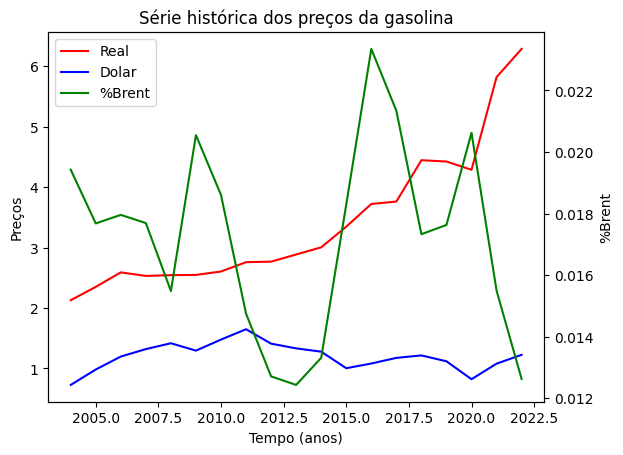

In [ ]:
# Criar o gráfico de linha usando o Matplotlib
# Criar uma figura e os eixos

x = df_join_ano.filter(df_join_ano["produto"]=='GASOLINA').select("ano").rdd.map(lambda row: row[0]).collect()
y1= df_join_ano.filter(df_join_ano["produto"]=='GASOLINA').select("venda").rdd.map(lambda row: row[0]).collect()
y2= df_join_ano.filter(df_join_ano["produto"]=='GASOLINA').select("venda_usd").rdd.map(lambda row: row[0]).collect()
y3= df_join_ano.filter(df_join_ano["produto"]=='GASOLINA').select("venda_brent").rdd.map(lambda row: row[0]).collect()

fig, ax1 = plt.subplots()

# Plotar a primeira linha (y1) no primeiro eixo
ax1.plot(x, y1, 'r', label='Real')
ax1.set_xlabel('Tempo (anos)')
ax1.set_ylabel('Preços')
#ax1.tick_params('y', colors='r')

ax1.plot(x, y2, 'b', label='Dolar')
ax1.set_ylabel('Preços')
#ax1.tick_params('y', colors='b')


# Criar um segundo eixo y
ax2 = ax1.twinx()

# Plotar a linha no segundo eixo
ax2.plot(x, y3, 'g', label='%Brent')
ax2.set_ylabel('%Brent')
#ax2.tick_params('y', colors='g')

# Adicionar legenda
lines = [ax1.get_lines()[0],ax1.get_lines()[1], ax2.get_lines()[0]]
ax1.legend(lines, [line.get_label() for line in lines])

# Título do gráfico
plt.title("Série histórica dos preços da gasolina")

# Exibir o gráfico
plt.xticks(rotation=90)
plt.show()

+----------+-------+
|   Produto|  Count|
+----------+-------+
|  GASOLINA|6878803|
|    ETANOL|6372551|
|    DIESEL|5062239|
|DIESEL S10|1775053|
|       GNV| 400324|
+----------+-------+



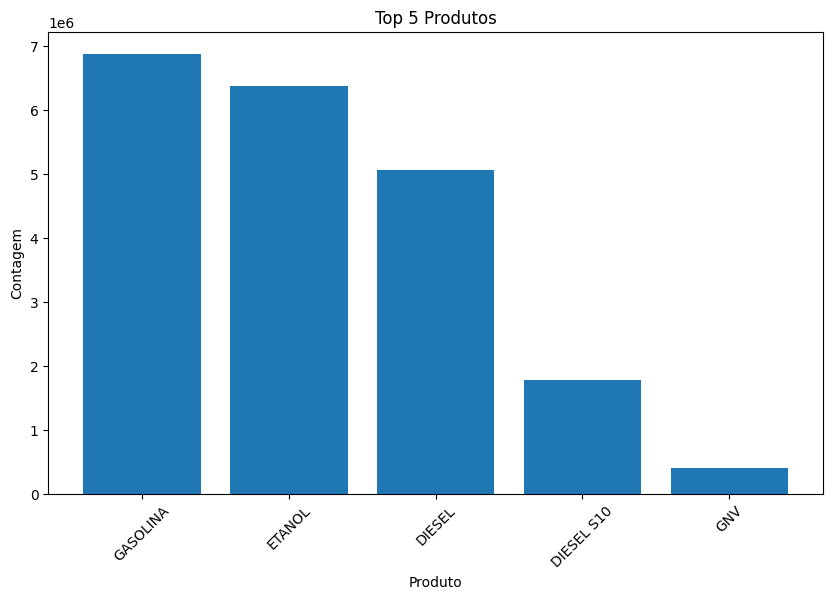

In [ ]:
# Conta os valores únicos na coluna 'Produtp'
count_values = df_base.groupBy('Produto').agg(count('Produto').alias('Count')).orderBy(desc('Count')).limit(5)

# Exibe o DataFrame resultante
count_values.show(5)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Converter o DataFrame Spark para Pandas DataFrame
df_Produto_Count = count_values.toPandas()

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df_Produto_Count['Produto'], df_Produto_Count['Count'])
plt.xlabel('Produto')
plt.ylabel('Contagem')
plt.title('Top 5 Produtos')
plt.xticks(rotation=45)
plt.show()

+--------------+--------+
|unidade_medida|   Count|
+--------------+--------+
|    R$ / litro|20473630|
|       R$ / m³|  391781|
+--------------+--------+



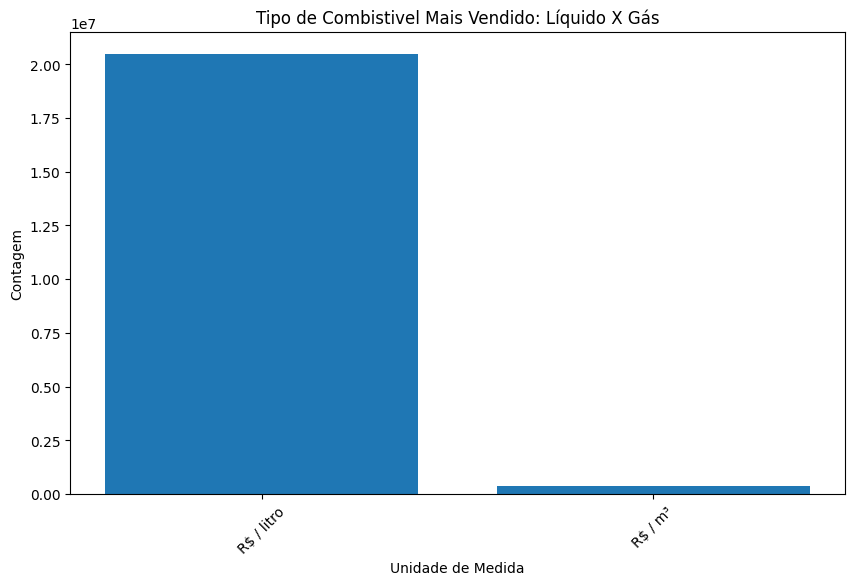

In [ ]:
# Conta os valores únicos na coluna 'Name'
count_values_Unidade = df_base.groupBy('unidade_medida').agg(count('unidade_medida').alias('Count')).orderBy(desc('Count')).limit(2)

# Exibe o DataFrame resultante
count_values_Unidade.show()

# Converter o DataFrame Spark para Pandas DataFrame
df_Unidade_Count = count_values_Unidade.toPandas()

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df_Unidade_Count['unidade_medida'], df_Unidade_Count['Count'])
plt.xlabel('Unidade de Medida')
plt.ylabel('Contagem')
plt.title('Tipo de Combistivel Mais Vendido: Líquido X Gás')
plt.xticks(rotation=45)
plt.show()

+--------------------+-------+
|            Bandeira|  Count|
+--------------------+-------+
|              BRANCA|6864191|
|PETROBRAS DISTRIB...|4506362|
|            IPIRANGA|2775627|
|              RAIZEN|2191930|
|                CBPI|1003564|
| COSAN LUBRIFICANTES| 907805|
|              ALESAT| 504168|
|       VIBRA ENERGIA| 354767|
|               SABBÁ| 147173|
|                  SP| 113570|
+--------------------+-------+



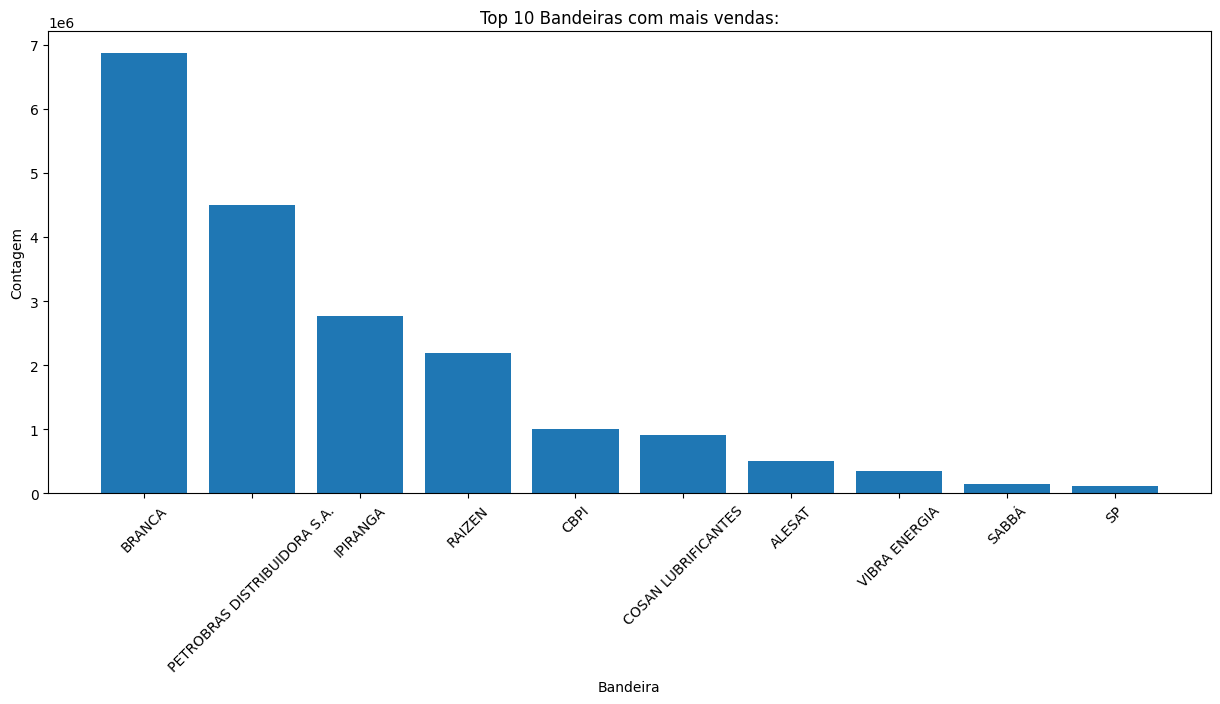

In [ ]:
# Conta os valores únicos na coluna 'Bandeira'
count_values_Bandeira = df_base.groupBy('Bandeira').agg(count('Bandeira').alias('Count')).orderBy(desc('Count')).limit(10)

# Exibe o DataFrame resultante
count_values_Bandeira.show()

# Converter o DataFrame Spark para Pandas DataFrame
df_Bandeira_Count = count_values_Bandeira.toPandas()

# Plotar o gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(df_Bandeira_Count['Bandeira'], df_Bandeira_Count['Count'])
plt.xlabel('Bandeira')
plt.ylabel('Contagem')
plt.title('Top 10 Bandeiras com mais vendas:')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from pyspark.sql.functions import avg, year, lag, col
from pyspark.sql.window import Window

# Agrupar por ano e calcular a média de venda
df_media_venda = df_base.groupBy(year("data").alias("Ano")).agg(avg("Venda").alias("Media_Venda"))

# Definir a janela para cálculo da variação
window = Window.orderBy("Ano")

# Calcular a variação da média de um ano para o outro
df_variacao_media = df_media_venda.withColumn("Variacao_Media", (col("Media_Venda") - lag("Media_Venda").over(window))/lag("Media_Venda").over(window))

# Criar o novo DataFrame com as colunas desejadas
df_novo = df_media_venda.join(df_variacao_media.select("Ano", "Variacao_Media"), "Ano")

# Exibir o novo DataFrame
df_novo.show()

+----+------------------+--------------------+
| Ano|       Media_Venda|      Variacao_Media|
+----+------------------+--------------------+
|2004|1.6423445330601878|-0.39786898447043495|
|2005|1.8554888436089982|   0.129780509666664|
|2006| 2.095840024189926| 0.12953523348242574|
|2007|1.9729555251322783|-0.05863257578790842|
|2008|2.0561402226441676| 0.04216247981885557|
|2009|2.0726455909522907| 0.00802735539451557|
|2010|2.1350772653818098| 0.03012173171431319|
|2011|2.2980474953505845| 0.07632989803749854|
|2012|2.3159238394236628|0.007778927158488116|
|2013|2.4530418370875675|0.059206609185398655|
|2014| 2.596848493964173| 0.05862380930581418|
|2015| 2.867088748540533| 0.10406469811561063|
|2016| 3.201035245087443|  0.1164758142617324|
|2017| 3.258524586144833|0.017959608893909504|
|2018|3.6991367839265985|  0.1352183131148489|
|2019|3.7614946167717918| 0.01685740119590847|
|2020|3.6579320823639407|-0.02753228303081581|
|2021| 5.183513515211317|  0.4170611696708891|
|2022| 6.0811

In [ ]:
# Filtrar os produtos desejados ('GNV', 'GASOLINA', 'ETANOL' e 'DIESEL')
produtos_desejados = ['GNV', 'GASOLINA', 'ETANOL', 'DIESEL']
df_filtrado = df_base.filter(col("produto").isin(produtos_desejados))

# Agrupar por ano e produto, e calcular a média de venda
df_media_venda = df_filtrado.groupBy(year("Data").alias("Ano"), "produto").agg(avg("Venda").alias("Media_Venda"))

# Definir a janela para cálculo da variação
window = Window.partitionBy("produto").orderBy("Ano")

# Calcular a variação da média de um ano para o outro para cada produto
df_variacao_media = df_media_venda.withColumn("Variacao_Media", (col("Media_Venda") - lag("Media_Venda").over(window)) / lag("Media_Venda").over(window))

# Criar o novo DataFrame com as colunas desejadas
df_novo = df_media_venda.join(df_variacao_media.select("Ano", "produto", "Variacao_Media"), ["Ano", "produto"])

# Exibir o novo DataFrame
df_novo.show(5)

+----+-------+------------------+--------------------+
| Ano|produto|       Media_Venda|      Variacao_Media|
+----+-------+------------------+--------------------+
|2004| DIESEL|1.5031167146599789| -0.3571668818073574|
|2005| DIESEL|1.7307097334478674| 0.15141406955837924|
|2006| DIESEL|1.8828698941867892| 0.08791778181994328|
|2007| DIESEL|1.8750129239742879|-0.00417286942489...|
|2008| DIESEL| 2.037314315449934| 0.08656014547976086|
+----+-------+------------------+--------------------+
only showing top 5 rows



In [ ]:
import pandas as pd

# Converter o DataFrame Spark para Pandas DataFrame
df_pandas = df_novo.toPandas()

<ipython-input-36-de79af54d40a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_produto['Ano'] = df_produto['Ano'].astype(int).astype(str).str[:4]  # Converter para string com 4 primeiros dígitos


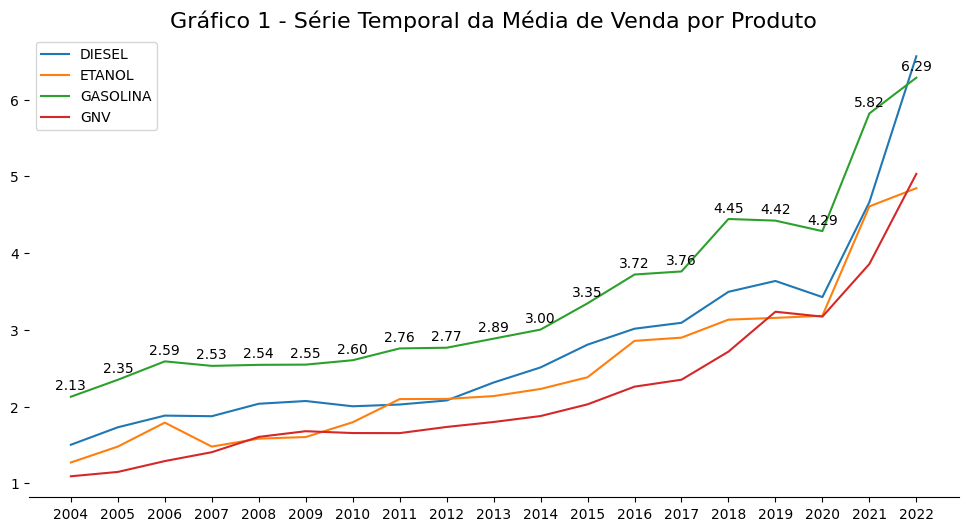

In [ ]:
import matplotlib.pyplot as plt

# Criar uma figura e um eixo com tamanho personalizado
fig, ax = plt.subplots(figsize=(12, 6))  # Definir a largura (12) e altura (6) da figura

# Iterar pelos produtos únicos e plotar as séries temporais com cores diferentes
for produto in df_pandas['produto'].unique():
    df_produto = df_pandas[df_pandas['produto'] == produto]
    df_produto['Ano'] = df_produto['Ano'].astype(int).astype(str).str[:4]  # Converter para string com 4 primeiros dígitos

    if produto == 'GASOLINA':
        ax.plot(df_produto['Ano'], df_produto['Media_Venda'], label=produto)

        # Adicionar rótulos aos pontos de dados
        for i, (ano, media_venda) in enumerate(zip(df_produto['Ano'], df_produto['Media_Venda'])):
            ax.annotate(f'{media_venda:.2f}', (ano, media_venda), textcoords="offset points", xytext=(0,5), ha='center')
    else:
        ax.plot(df_produto['Ano'], df_produto['Media_Venda'], label=produto)

# Configurar o título e as legendas
ax.set_title('Gráfico 1 - Série Temporal da Média de Venda por Produto',fontsize=16)
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Exibir o gráfico
plt.show()

In [ ]:
# Filtrar as linhas com data_coleta maior que 2019
df_filtered = df_base.filter(df_base.data >= '2022-01-01')

In [ ]:
import pyspark.sql.functions as F

# Calcular estatísticas descritivas da coluna valor_venda agrupado por cidade
df_stats = df_filtered.groupBy('municipio').agg(
    F.mean('venda').alias('mean'),
    F.expr('percentile_approx(venda, 0.25)').alias('q1'),
    F.expr('percentile_approx(venda, 0.5)').alias('median'),
    F.expr('percentile_approx(venda, 0.75)').alias('q3'),
    F.stddev('venda').alias('std_dev')
)

# Converter o DataFrame do Spark para um DataFrame do pandas
df_pandas = df_stats.toPandas()

In [ ]:
df_pandas.sort_values(by='mean', ascending=False).head(5)

,municipio,mean,q1,median,q3,std_dev
128,CRUZEIRO DO SUL,7.552936,6.80,7.60,7.98,0.777210
418,TEFE,7.500713,7.00,7.39,7.95,0.612951
301,PARINTINS,7.459456,6.99,7.65,7.75,0.593098
6,ALENQUER,7.258300,6.42,7.42,7.94,0.804775
112,CONCEICAO DO ARAGUAIA,7.165969,6.39,7.30,7.88,0.764905


In [ ]:
df_pandas.sort_values(by='std_dev', ascending=False).head(5)

,municipio,mean,q1,median,q3,std_dev
339,PRESIDENTE PRUDENTE,5.544274,4.58,5.59,6.87,1.373784
445,VARZEA GRANDE,5.570920,4.59,5.77,6.73,1.335712
155,GOIANIA,5.830003,4.89,5.79,6.99,1.315507
14,ANAPOLIS,5.794854,4.77,5.87,6.89,1.308590
281,NOVA LIMA,5.779833,4.97,5.39,6.99,1.302104


In [ ]:
# Todos os anos
df_filtered2 = df_base


# Calcular estatísticas descritivas da coluna valor_venda agrupado por cidade
df_stats2 = df_filtered2.groupBy('municipio').agg(
    F.mean('venda').alias('mean'),
    F.expr('percentile_approx(venda, 0.25)').alias('q1'),
    F.expr('percentile_approx(venda, 0.5)').alias('median'),
    F.expr('percentile_approx(venda, 0.75)').alias('q3'),
    F.stddev('venda').alias('std_dev')
)

# Converter o DataFrame do Spark para um DataFrame do pandas
df_pandas2 = df_stats2.toPandas()

In [ ]:
df_pandas2.sort_values(by='mean', ascending=False).head(5)

,municipio,mean,q1,median,q3,std_dev
492,JAPARATUBA,6.118889,5.540,6.180,6.490,0.866421
603,ROSARIO DO SUL,5.653919,4.700,5.896,6.179,0.849231
333,ANAMA,4.225630,4.070,4.199,4.290,0.354479
684,VARGEAO,4.099000,3.699,3.699,4.499,0.461880
100,CRUZEIRO DO SUL,3.986264,2.840,3.450,4.650,1.483693


In [ ]:
df_pandas2.sort_values(by='std_dev', ascending=False).head(5)

,municipio,mean,q1,median,q3,std_dev
528,MESQUITA,3.560860,1.699,2.429,5.590,2.162487
326,ALENQUER,3.763054,2.550,3.150,4.430,1.597510
426,DELMIRO GOUVEIA,3.421579,2.377,2.990,3.990,1.491112
100,CRUZEIRO DO SUL,3.986264,2.840,3.450,4.650,1.483693
574,PETROPOLIS,2.995414,1.969,2.620,3.499,1.447245


In [ ]:
df_filtered.show(5)

+------+---+---------+-------------------+------+------------------+--------------+-------------+----------+-----+----------+
|regiao| uf|municipio|               cnpj|bairro|           produto|unidade_medida|     bandeira|      data|venda|ano_coleta|
+------+---+---------+-------------------+------+------------------+--------------+-------------+----------+-----+----------+
|    SE| ES| COLATINA| 08.519.545/0001-10|  LACE|GASOLINA ADITIVADA|    R$ / litro|VIBRA ENERGIA|2022-01-07| 7.48|      2022|
|    SE| ES| COLATINA| 08.519.545/0001-10|  LACE|          GASOLINA|    R$ / litro|VIBRA ENERGIA|2022-01-07| 7.38|      2022|
|    SE| ES| COLATINA| 04.814.652/0001-10|  LACE|        DIESEL S10|    R$ / litro|VIBRA ENERGIA|2022-01-07| 7.69|      2022|
|    SE| ES| COLATINA| 04.814.652/0001-10|  LACE|            ETANOL|    R$ / litro|VIBRA ENERGIA|2022-01-07| 5.99|      2022|
|    SE| ES| COLATINA| 04.814.652/0001-10|  LACE|          GASOLINA|    R$ / litro|VIBRA ENERGIA|2022-01-07| 7.39|    

In [ ]:
# AGRUPAR POR REGIAO GEOGRAFICA, gasolina e ano = 2022



# Calcular estatísticas descritivas da coluna valor_venda agrupado por cidade, filtrando apenas o produto "gasolina"
df_stats = df_filtered.filter((df_filtered.produto == 'GASOLINA') & (df_filtered.ano_coleta == '2022')).groupBy('regiao').agg(
    F.mean('venda').alias('mean'),
    F.expr('percentile_approx(venda, 0.25)').alias('q1'),
    F.expr('percentile_approx(venda, 0.5)').alias('median'),
    F.expr('percentile_approx(venda, 0.75)').alias('q3'),
    F.stddev('venda').alias('std_dev')
)

# Converter o DataFrame do Spark para um DataFrame do pandas
df_pandas3 = df_stats.toPandas()

In [ ]:
df_pandas3.sort_values(by='mean', ascending=False).head(5)


,regiao,mean,q1,median,q3,std_dev
0,NE,6.515582,5.69,6.68,7.19,0.943995
1,N,6.432225,5.56,6.67,7.25,0.954555
4,CO,6.274685,5.35,6.45,6.99,0.956849
3,SE,6.210831,5.38,6.29,6.95,0.951695
2,S,6.182854,5.46,6.39,6.79,0.830251


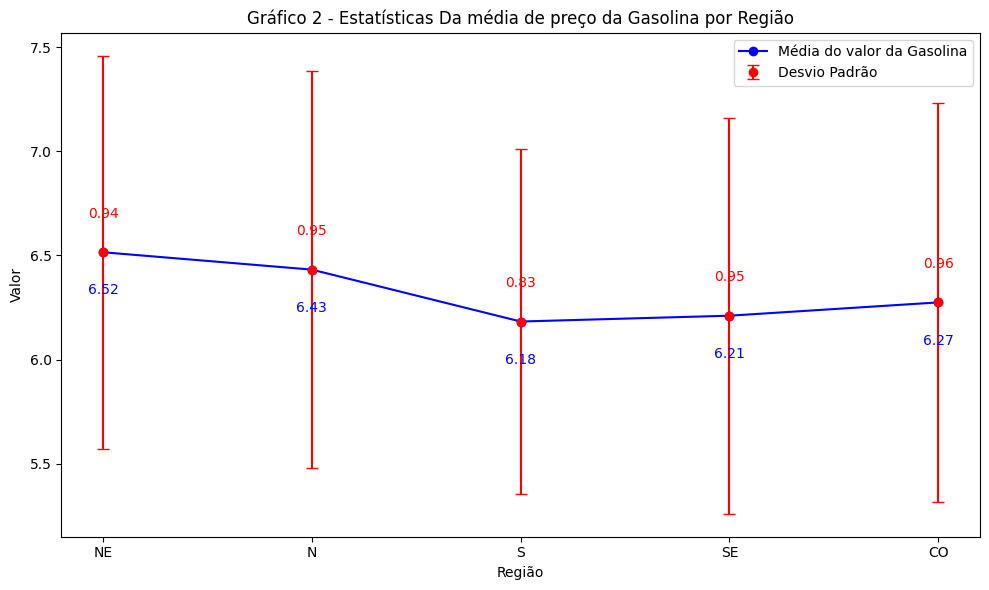

In [ ]:
# Configurar o gráfico
plt.figure(figsize=(10, 6)) # Tamanho da figura
plt.errorbar(df_pandas3['regiao'], df_pandas3['mean'], yerr=df_pandas3['std_dev'], fmt='o', color='red', capsize=4, label='Desvio Padrão')
plt.plot(df_pandas3['regiao'], df_pandas3['mean'], linestyle='-', marker='o', color='blue', label='Média do valor da Gasolina')

# Adicionar rótulos dos valores do desvio padrão
for i in range(len(df_pandas3)):
    plt.text(df_pandas3['regiao'][i], df_pandas3['mean'][i]+0.15, f"{df_pandas3['std_dev'][i]:.2f}", ha='center', va='bottom', color='red')

# Adicionar rótulos dos valores da média
for i in range(len(df_pandas3)):
    plt.text(df_pandas3['regiao'][i], df_pandas3['mean'][i] - 0.15, f"{df_pandas3['mean'][i]:.2f}", ha='center', va='top', color='blue')



# Títulos e legendas
plt.title('Gráfico 2 - Estatísticas Da média de preço da Gasolina por Região')
plt.xlabel('Região')
plt.ylabel('Valor')
plt.legend()

# Ajustar layout para melhor visibilidade dos rótulos
plt.tight_layout()



# Exibir o gráfico
plt.show()
fig.savefig('esta.png')


In [ ]:
# AGRUPAR POR ESTADO

# Calcular estatísticas descritivas da coluna valor_venda agrupado por cidade
df_stats = df_filtered.groupBy('uf').agg(
    F.mean('venda').alias('mean'),
    F.expr('percentile_approx(venda, 0.25)').alias('q1'),
    F.expr('percentile_approx(venda, 0.5)').alias('median'),
    F.expr('percentile_approx(venda, 0.75)').alias('q3'),
    F.stddev('venda').alias('std_dev')
)

# Converter o DataFrame do Spark para um DataFrame do pandas
df_pandas4 = df_stats.toPandas()

In [ ]:
df_pandas4.sort_values(by='mean', ascending=False).head(100)


,uf,mean,q1,median,q3,std_dev
23,AC,6.972879,6.24,7.07,7.63,0.923561
15,PA,6.633545,5.89,6.84,7.39,0.979034
1,RO,6.601530,5.87,6.79,7.30,0.892885
2,PI,6.498953,5.59,6.78,7.39,1.135467
4,RR,6.479698,5.84,6.55,7.11,0.806663
16,BA,6.470420,5.63,6.64,7.35,1.084013
22,MA,6.391050,5.59,6.60,7.15,0.964648
20,RN,6.385827,5.64,6.49,7.18,0.991269
19,CE,6.377358,5.65,6.47,7.19,1.000385
6,TO,6.317052,5.59,6.49,6.99,0.912486
